<a href="https://colab.research.google.com/github/srinivasbharani/Advanced-Regression---Machine-Learning/blob/main/FGSM_3_Defenses_Version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, utils
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

# Normalize pixel values to [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert labels to one-hot encoded vectors
y_train = utils.to_categorical(y_train, num_classes=10)
y_test = utils.to_categorical(y_test, num_classes=10)

In [3]:
# Create DNN model
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

In [4]:
# Fast Gradient Sign Method (FGSM) attack
def fgsm_attack(model, x, y, epsilon=0.05):
    x = tf.convert_to_tensor(x)  # Convert input to Tensor if not already
    y = tf.convert_to_tensor(y)  # Convert labels to Tensor if not already

    with tf.GradientTape() as tape:
        tape.watch(x)
        predictions = model(x)
        loss = tf.keras.losses.categorical_crossentropy(y, predictions)
    gradient = tape.gradient(loss, x)
    x_adv = x + epsilon * tf.sign(gradient)
    x_adv = tf.clip_by_value(x_adv, 0, 1)
    return x_adv


In [5]:
# # Adversarial Training
# def adversarial_training(model, x_train, y_train, epsilon=0.05, epochs=10, batch_size=32):
#     for epoch in range(epochs):
#         x_train_adv = fgsm_attack(model, x_train, y_train, epsilon=epsilon)
#         model.fit(x_train_adv, y_train, epochs=1, batch_size=batch_size)
#         return model


In [6]:
# Helper function for defensive distillation
def softmax_with_temperature(logits, temperature):
    exp_logits = np.exp(logits / temperature)
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)


In [7]:
# Generate adversarial data
x_test_adv = fgsm_attack(create_model(), x_test, y_test, epsilon=0.05)
print(len(x_test_adv))

10000


In [8]:
# Create and train the clean model
clean_model = create_model()
clean_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
clean_model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.4971 - accuracy: 0.4550 - val_loss: 1.2225 - val_accuracy: 0.5601
Epoch 2/10
1563/1563 [==============================] - 16s 10ms/step - loss: 1.1222 - accuracy: 0.6047 - val_loss: 1.0716 - val_accuracy: 0.6259
Epoch 3/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.9650 - accuracy: 0.6616 - val_loss: 1.0207 - val_accuracy: 0.6505
Epoch 4/10
1563/1563 [==============================] - 18s 12ms/step - loss: 0.8731 - accuracy: 0.6942 - val_loss: 0.8889 - val_accuracy: 0.6933
Epoch 5/10
1563/1563 [==============================] - 18s 11ms/step - loss: 0.8001 - accuracy: 0.7176 - val_loss: 0.8866 - val_accuracy: 0.6993
Epoch 6/10
1563/1563 [==============================] - 18s 11ms/step - loss: 0.7370 - accuracy: 0.7423 - val_loss: 0.8491 - val_accuracy: 0.7104
Epoch 7/10
1563/1563 [==============================] - 18s 11ms/step - loss: 0.6870 - accuracy: 0.7587 - val_loss: 0.8791 - 

In [9]:
print(len(x_train))

50000


In [10]:
# Evaluate accuracy on clean test data
_, clean_accuracy = clean_model.evaluate(x_test, y_test, verbose=0)
print(clean_accuracy)

0.7077000141143799


In [11]:
# Evaluate accuracy on adversarial test data
_, clean_adv_accuracy = clean_model.evaluate(x_test_adv, y_test, verbose=0)
print(clean_adv_accuracy)

0.6862000226974487


In [12]:
# Adversarial Training with FGSM attack on clean model
adv_model = create_model()
adv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# adversarial_training(adv_model, x_train, y_train)#, epsilon=0.05, epochs=10, batch_size=32)
x_train_adv = fgsm_attack(clean_model, x_train, y_train, epsilon=0.05)
print(len(x_train_adv))
x_train_adv_2 = np.concatenate([x_train, x_train_adv])
print(len(x_train_adv_2))
y_train_2 = np.concatenate([y_train, y_train])
print(len(y_train_2))

50000
100000
100000


In [13]:
adv_model.fit(x_train_adv_2, y_train_2, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
3125/3125 [==============================] - 26s 8ms/step - loss: 1.5091 - accuracy: 0.4477 - val_loss: 1.2731 - val_accuracy: 0.5398
Epoch 2/10
3125/3125 [==============================] - 26s 8ms/step - loss: 1.2382 - accuracy: 0.5542 - val_loss: 1.1068 - val_accuracy: 0.5994
Epoch 3/10
3125/3125 [==============================] - 26s 8ms/step - loss: 1.1108 - accuracy: 0.6040 - val_loss: 1.0644 - val_accuracy: 0.6203
Epoch 4/10
3125/3125 [==============================] - 26s 8ms/step - loss: 1.0093 - accuracy: 0.6395 - val_loss: 1.0843 - val_accuracy: 0.6124
Epoch 5/10
3125/3125 [==============================] - 26s 8ms/step - loss: 0.9265 - accuracy: 0.6701 - val_loss: 1.1188 - val_accuracy: 0.6083
Epoch 6/10
3125/3125 [==============================] - 26s 8ms/step - loss: 0.8557 - accuracy: 0.6957 - val_loss: 1.0490 - val_accuracy: 0.6385
Epoch 7/10
3125/3125 [==============================] - 26s 8ms/step - loss: 0.7888 - accuracy: 0.7196 - val_loss: 1.1262 - val_ac

In [14]:
# Evaluate accuracy of adversarial training model on clean test data
_, adv_train_accuracy_clean = adv_model.evaluate(x_test, y_test, verbose=0)
print(adv_train_accuracy_clean)

0.6194999814033508


In [15]:
# Evaluate accuracy of adversarial training model on adversarial test data
_, adv_train_accuracy_adv = adv_model.evaluate(x_test_adv, y_test, verbose=0)
print(adv_train_accuracy_adv)

0.6086000204086304


In [16]:
# Adversarial Training with Gradient Masking
adv_model_gm = create_model()
adv_model_gm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
for _ in range(10):
    x_train_masked = x_train + 0.1 * np.sign(np.random.randn(*x_train.shape))
    x_train_masked = np.clip(x_train_masked, 0, 1)
#     adv_model_gm.fit(x_train_masked, y_train, epochs=1, batch_size=32)
    adv_model.fit(x_train_masked, y_train, epochs=1, batch_size=32)
    


1563/1563 [==============================] - 12s 8ms/step - loss: 0.5906 - accuracy: 0.7877


In [17]:
# Evaluate accuracy on adversarial training model with gradient masking
_, adv_train_accuracy_gm_clean = adv_model.evaluate(x_test, y_test, verbose=0)
print(adv_train_accuracy_gm_clean)

0.6276999711990356


In [18]:
# Evaluate accuracy on adversarial test data with gradient masking
_, adv_train_accuracy_gm_adv = adv_model.evaluate(x_test_adv, y_test, verbose=0)
print(adv_train_accuracy_gm_adv)

0.6413999795913696


In [22]:
# Defensive Distillation
defensive_distillation_model = create_model()
defensive_distillation_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [23]:
# Soft targets from the trained model with temperature
temperature = 3.0
soft_targets = softmax_with_temperature(adv_model.predict(x_train), temperature)
soft_targets_test = softmax_with_temperature(adv_model.predict(x_test), temperature)


defensive_distillation_model.fit(x_train, soft_targets, epochs=10, batch_size=32)

313/313 [==============================] - 1s 3ms/step
Epoch 1/10
1563/1563 [==============================] - 12s 8ms/step - loss: 2.3011 - accuracy: 0.5048
Epoch 2/10
1563/1563 [==============================] - 12s 8ms/step - loss: 2.3003 - accuracy: 0.6406
Epoch 3/10
1563/1563 [==============================] - 12s 8ms/step - loss: 2.3001 - accuracy: 0.6835
Epoch 4/10
1563/1563 [==============================] - 12s 8ms/step - loss: 2.3000 - accuracy: 0.7061
Epoch 5/10
1563/1563 [==============================] - 12s 8ms/step - loss: 2.2999 - accuracy: 0.7241
Epoch 6/10
1563/1563 [==============================] - 13s 8ms/step - loss: 2.2998 - accuracy: 0.7385
Epoch 7/10
1563/1563 [==============================] - 13s 8ms/step - loss: 2.2997 - accuracy: 0.7469
Epoch 8/10
1563/1563 [==============================] - 13s 8ms/step - loss: 2.2997 - accuracy: 0.7588
Epoch 9/10
1563/1563 [==============================] - 12s 8ms/step - loss: 2.2996 - accuracy: 0.7664
Epoch 10/10
1563/1

In [25]:
# Evaluate accuracy of defensive distillation model on clean and adversarial test data
_, defensive_distillation_clean_accuracy = defensive_distillation_model.evaluate(x_test, y_test, verbose=0)
x_test_adv_soft = softmax_with_temperature(clean_model.predict(x_test_adv), temperature)
_, defensive_distillation_adv_accuracy = defensive_distillation_model.evaluate(x_test_adv, x_test_adv_soft, verbose=0)
print(defensive_distillation_clean_accuracy)
print(defensive_distillation_adv_accuracy)

313/313 [==============================] - 1s 3ms/step
0.6947000026702881
0.695900022983551


In [26]:
# Calculate robustness scores
robustness_score_clean = clean_adv_accuracy / clean_accuracy
robustness_score_adv = adv_train_accuracy_adv / clean_accuracy
robustness_score_gm_clean = adv_train_accuracy_gm_clean / clean_accuracy
robustness_score_gm_adv = adv_train_accuracy_gm_adv / clean_accuracy
robustness_score_dd_clean = defensive_distillation_clean_accuracy / clean_accuracy
robustness_score_dd_adv = defensive_distillation_adv_accuracy / clean_accuracy


In [27]:
# Generate confusion matrices
def generate_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


313/313 [==============================] - 1s 3ms/step


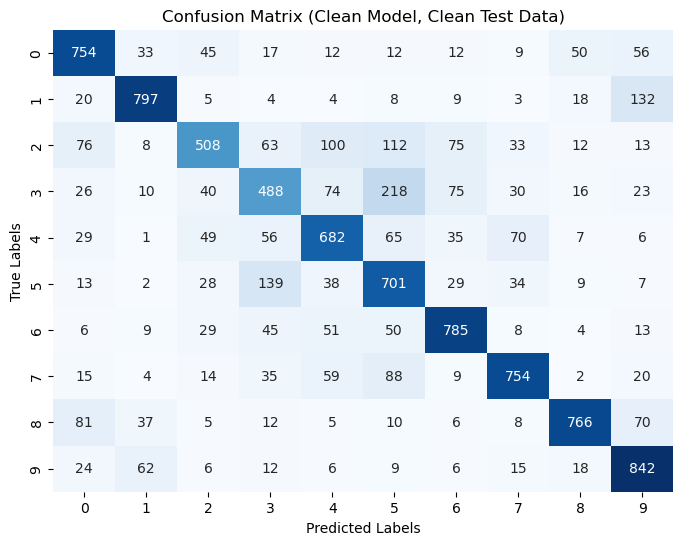

In [28]:
# Confusion matrix for clean model on clean test data
y_pred_clean = np.argmax(clean_model.predict(x_test), axis=1)
generate_confusion_matrix(np.argmax(y_test, axis=1), y_pred_clean, "Confusion Matrix (Clean Model, Clean Test Data)")


313/313 [==============================] - 1s 3ms/step


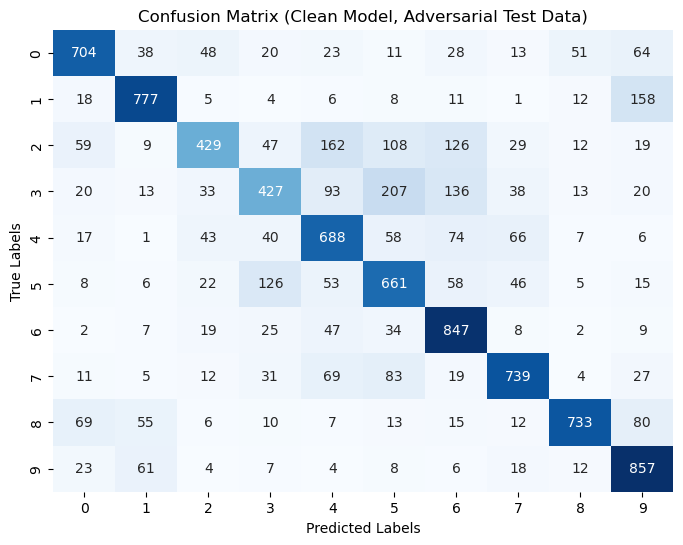

In [29]:
# Confusion matrix for clean model on adversarial test data
y_pred_clean_adv = np.argmax(clean_model.predict(x_test_adv), axis=1)
generate_confusion_matrix(np.argmax(y_test, axis=1), y_pred_clean_adv, "Confusion Matrix (Clean Model, Adversarial Test Data)")


313/313 [==============================] - 1s 3ms/step


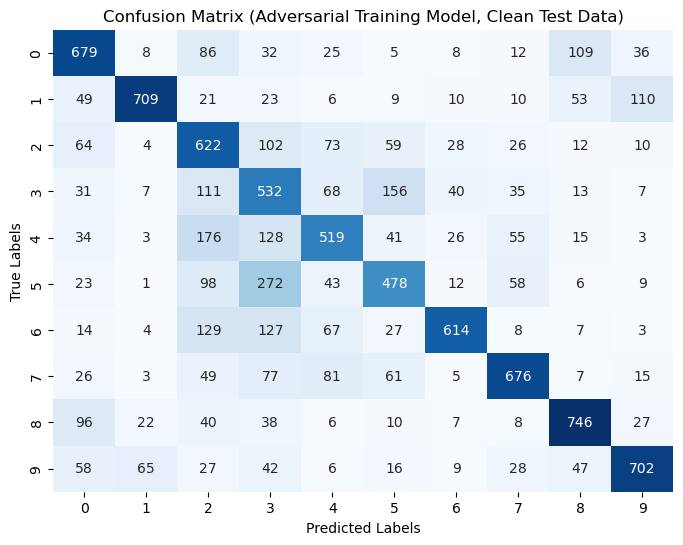

In [30]:
# Confusion matrix for adversarial training model on clean test data
y_pred_adv_train_clean = np.argmax(adv_model.predict(x_test), axis=1)
generate_confusion_matrix(np.argmax(y_test, axis=1), y_pred_adv_train_clean, "Confusion Matrix (Adversarial Training Model, Clean Test Data)")


313/313 [==============================] - 1s 3ms/step


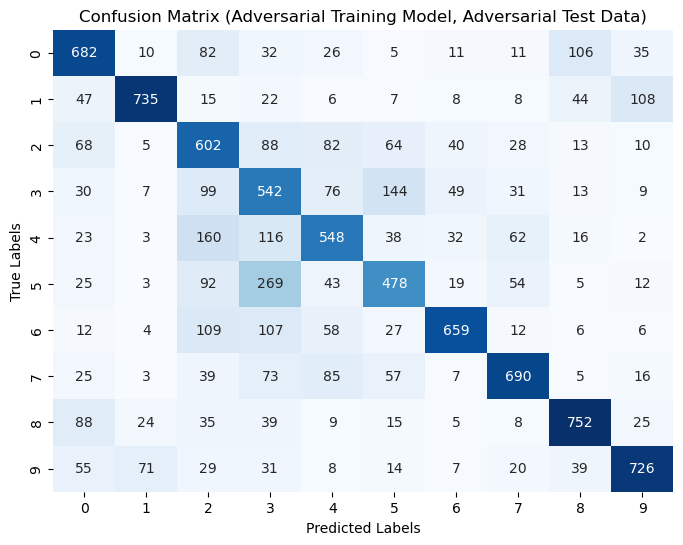

In [31]:
# Confusion matrix for adversarial training model on adversarial test data
y_pred_adv_train_adv = np.argmax(adv_model.predict(x_test_adv), axis=1)
generate_confusion_matrix(np.argmax(y_test, axis=1), y_pred_adv_train_adv, "Confusion Matrix (Adversarial Training Model, Adversarial Test Data)")


313/313 [==============================] - 1s 3ms/step


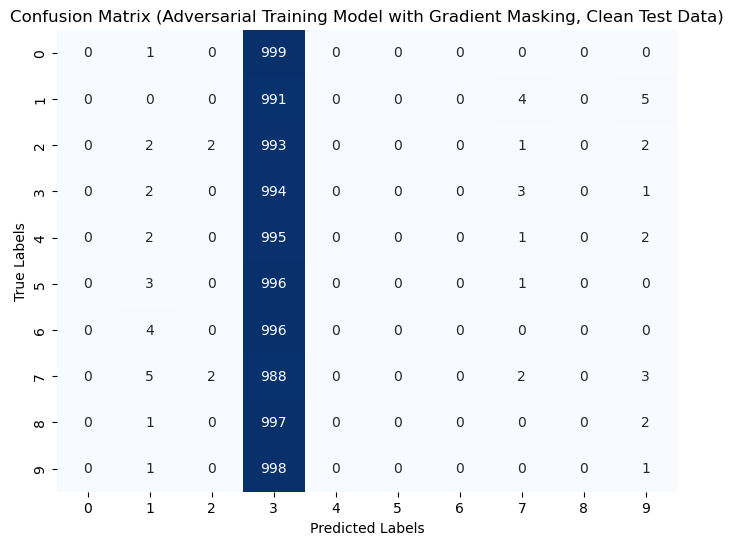

In [32]:
# Confusion matrix for adversarial training model with gradient masking on clean test data
y_pred_adv_train_gm_clean = np.argmax(adv_model_gm.predict(x_test), axis=1)
generate_confusion_matrix(np.argmax(y_test, axis=1), y_pred_adv_train_gm_clean, "Confusion Matrix (Adversarial Training Model with Gradient Masking, Clean Test Data)")


313/313 [==============================] - 1s 3ms/step


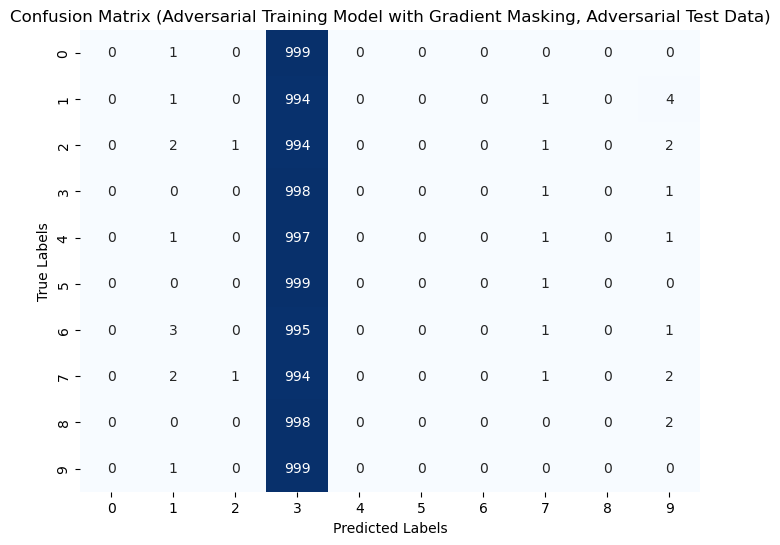

In [33]:
# Confusion matrix for adversarial training model with gradient masking on adversarial test data
y_pred_adv_train_gm_adv = np.argmax(adv_model_gm.predict(x_test_adv), axis=1)
generate_confusion_matrix(np.argmax(y_test, axis=1), y_pred_adv_train_gm_adv, "Confusion Matrix (Adversarial Training Model with Gradient Masking, Adversarial Test Data)")


313/313 [==============================] - 1s 3ms/step


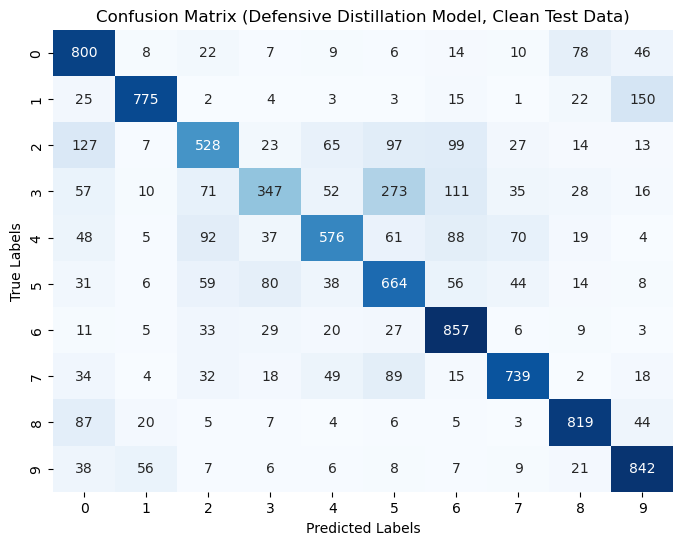

In [34]:
# Confusion matrix for defensive distillation model on clean test data
y_pred_def_dist_clean = np.argmax(defensive_distillation_model.predict(x_test), axis=1)
generate_confusion_matrix(np.argmax(y_test, axis=1), y_pred_def_dist_clean, "Confusion Matrix (Defensive Distillation Model, Clean Test Data)")


313/313 [==============================] - 1s 3ms/step


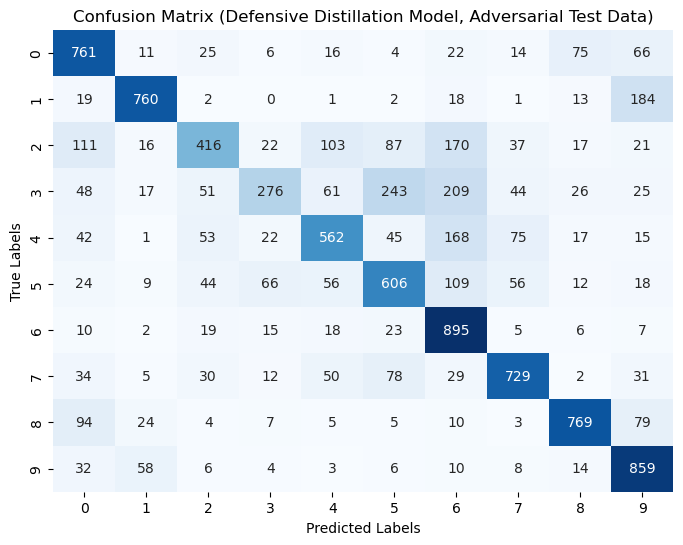

In [35]:
# Confusion matrix for defensive distillation model on adversarial test data
y_pred_def_dist_adv = np.argmax(defensive_distillation_model.predict(x_test_adv), axis=1)
generate_confusion_matrix(np.argmax(y_test, axis=1), y_pred_def_dist_adv, "Confusion Matrix (Defensive Distillation Model, Adversarial Test Data)")


In [36]:
# Print accuracy and robustness scores
print("Clean Model Accuracy:", clean_accuracy)
print("Clean Model Robustness Score:", robustness_score_clean)

print("Adversarial Training Model Accuracy on Clean Data:", adv_train_accuracy_clean)
print("Adversarial Training Model Robustness Score on Clean Data:", robustness_score_adv)

print("Adversarial Training Model with Gradient Masking Accuracy on Clean Data:", adv_train_accuracy_gm_clean)
print("Adversarial Training Model with Gradient Masking Robustness Score on Clean Data:", robustness_score_gm_clean)

print("Defensive Distillation Model Accuracy on Clean Data:", defensive_distillation_clean_accuracy)
print("Defensive Distillation Model Robustness Score on Clean Data:", robustness_score_dd_clean)

Clean Model Accuracy: 0.7077000141143799
Clean Model Robustness Score: 0.9696199081699378
Adversarial Training Model Accuracy on Clean Data: 0.6194999814033508
Adversarial Training Model Robustness Score on Clean Data: 0.8599689250681112
Adversarial Training Model with Gradient Masking Accuracy on Clean Data: 0.6276999711990356
Adversarial Training Model with Gradient Masking Robustness Score on Clean Data: 0.8869576920731636
Defensive Distillation Model Accuracy on Clean Data: 0.6947000026702881
Defensive Distillation Model Robustness Score on Clean Data: 0.9816306186451613


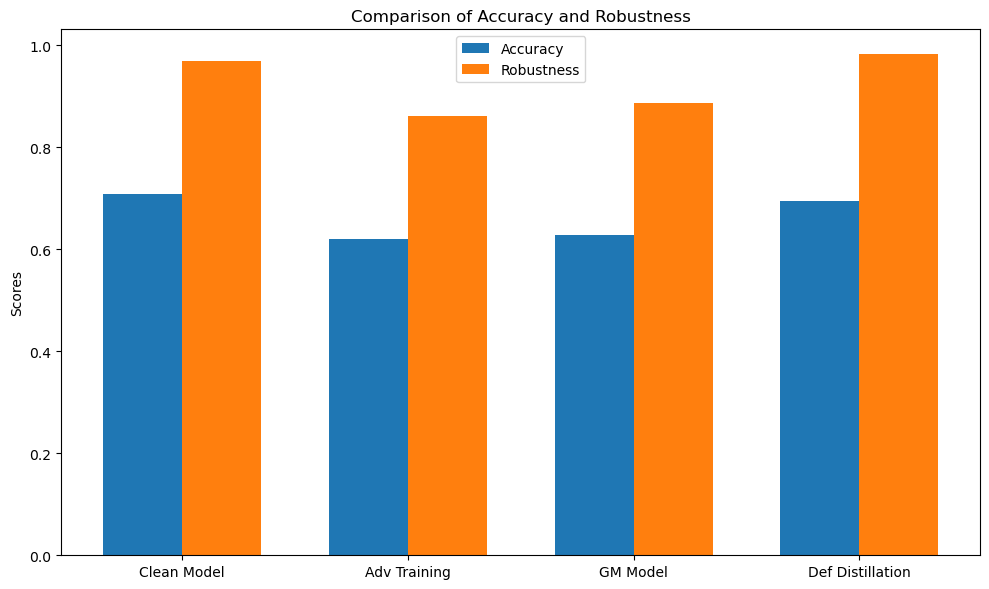

In [37]:
# Plot comparison graph
labels = ['Clean Model', 'Adv Training', 'GM Model', 'Def Distillation']
accuracy_scores = [clean_accuracy, adv_train_accuracy_clean, adv_train_accuracy_gm_clean, defensive_distillation_clean_accuracy]
robustness_scores = [robustness_score_clean, robustness_score_adv, robustness_score_gm_clean, robustness_score_dd_clean]

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(labels))
width = 0.35

rects1 = ax.bar(x - width/2, accuracy_scores, width, label='Accuracy')
rects2 = ax.bar(x + width/2, robustness_scores, width, label='Robustness')

ax.set_ylabel('Scores')
ax.set_title('Comparison of Accuracy and Robustness')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()